
# Set up the notebook

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, osp.join('..', 'py'))

from stats_scraping_utils import StatsScrapingUtilities
from storage import Storage
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
import numpy as np
import re
from scipy.stats import pearsonr
%matplotlib inline

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

s = Storage()
ssu = StatsScrapingUtilities(s=s)


----


# Prepare the Canadian Provinces scatterplot


## Get the Canadian Obesity data

In [13]:

url = 'https://www150.statcan.gc.ca/n1/pub/11-627-m/11-627-m2018033-eng.htm'
# obesity_ca_provinces_df = s.load_object('obesity_ca_provinces_df')
tables_list = ssu.get_page_tables(url)

[(5, (10, 3)), (0, (4, 2)), (1, (3, 2)), (2, (3, 2)), (4, (3, 2)), (3, (2, 2))]


In [14]:

obesity_ca_provinces_df = tables_list[5].copy()
obesity_ca_provinces_df.columns = ['province_name', 'obesity_percent', 'comparison_notes']
def f(x):
    rate_float = np.nan
    rate_str = str(x)
    if '%' in rate_str:
        rate_float = float(rate_str.split('%')[0])
    
    return rate_float
for cn in ['obesity_percent']:
    obesity_ca_provinces_df[cn] = obesity_ca_provinces_df[cn].map(f)
obesity_ca_provinces_df.sample(5)

,province_name,obesity_percent,comparison_notes
7,Newfoundland and Labrador,38.0,Higher than the Canadian average
3,Manitoba,29.0,Same as the Canadian average
9,Nova Scotia,35.0,Higher than the Canadian average
6,New Brunswick,38.0,Higher than the Canadian average
4,Ontario,26.0,Lower than the Canadian average



## Get the Canadian Income Inequality data

In [15]:

url = 'https://www.statista.com/statistics/613032/measure-of-income-inequality-in-canada-by-province/'
# income_inequality_ca_provinces_df = s.load_object('income_inequality_ca_provinces_df')
tables_list = ssu.get_page_tables(url)

[(0, (10, 2)), (1, (7, 4))]


In [16]:

income_inequality_ca_provinces_df = tables_list[0].copy()
income_inequality_ca_provinces_df.columns = ['province_name', 'gini_coefficient']
for cn in ['gini_coefficient']:
    income_inequality_ca_provinces_df[cn] = income_inequality_ca_provinces_df[cn].map(lambda x: re.sub(r'[^0-9\.]+', '', str(x)))
    income_inequality_ca_provinces_df[cn] = pd.to_numeric(income_inequality_ca_provinces_df[cn], errors='coerce', downcast='float')
income_inequality_ca_provinces_df.sample(5)

,province_name,gini_coefficient
2,British Columbia,0.30
8,Quebec,0.28
0,Ontario,0.31
9,Prince Edward Island,0.26
1,Alberta,0.29



## Create the Provinces scatterplot

In [17]:

# Explanatory variable
xname = 'gini_coefficient'

# Response variable
yname = 'obesity_percent'

# Remove NaNs
columns_list = ['province_name', xname, yname]
df = obesity_ca_provinces_df.merge(income_inequality_ca_provinces_df, on='province_name', how='inner')[columns_list].dropna()
xdata = df[xname]
ydata = df[yname]

In [18]:

df.sample(5)

,province_name,gini_coefficient,obesity_percent
1,Alberta,0.29,29.0
3,Manitoba,0.29,29.0
0,British Columbia,0.30,22.0
4,Ontario,0.31,26.0
5,Quebec,0.28,27.0


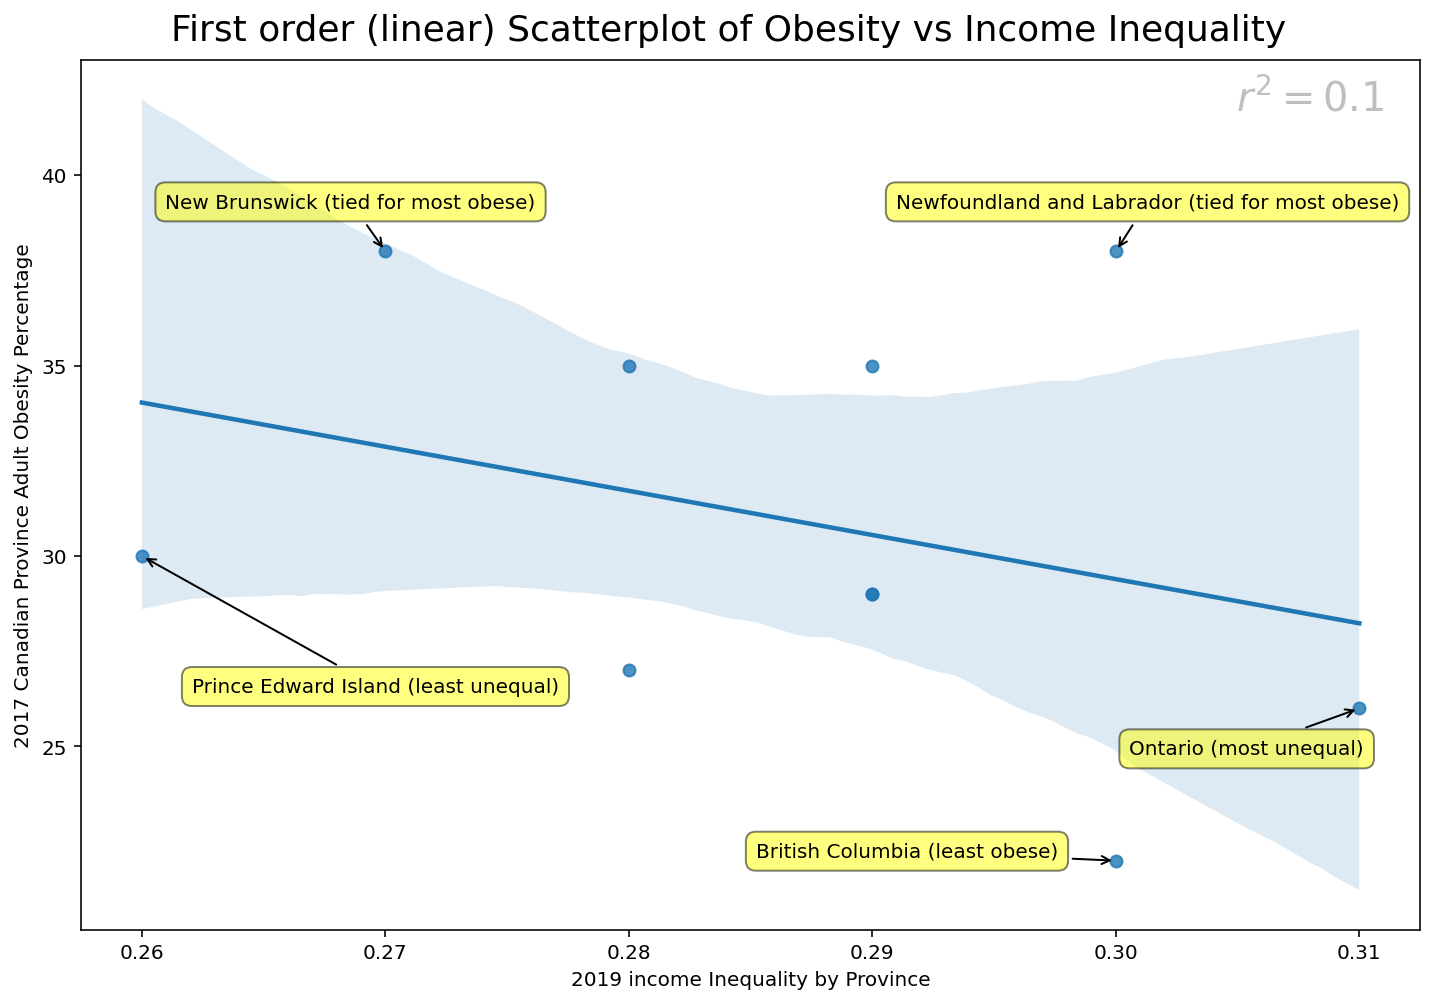

In [19]:

# First order (linear) scatterplot
fig = plt.figure(figsize=(12,8))
merge_axes_subplot = sns.regplot(x=xname, y=yname, scatter=True, data=df)
xlabel_str = '2019 income Inequality by Province'
xlabel_text = plt.xlabel(xlabel_str)
ylabel_str = '2017 Canadian Province Adult Obesity Percentage'
ylabel_text = plt.ylabel(ylabel_str)
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
least_unequal = xdata.min()
most_unequal = xdata.max()
most_obese = ydata.max()
least_obese = ydata.min()
for label, x, y in zip(df['province_name'], xdata, ydata):
    if (x == least_unequal):
        annotation = plt.annotate('{} (least unequal)'.format(label),
                                  xy=(x, y), xytext=(25, -70), **kwargs)
    elif (x == most_unequal):
        annotation = plt.annotate('{} (most unequal)'.format(label),
                                  xy=(x, y), xytext=(-115, -25), **kwargs)
    elif (y == most_obese):
        annotation = plt.annotate('{} (tied for most obese)'.format(label),
                                  xy=(x, y), xytext=(-110, 20), **kwargs)
    elif (y == least_obese):
        annotation = plt.annotate('{} (least obese)'.format(label),
                                  xy=(x, y), xytext=(-180, 0), **kwargs)

# Add r-squared
plt.text(0.308, 42, r'$r^2 = {0:.2}$'.format(pearsonr(xdata, ydata)[0] ** 2), fontsize=20, alpha=0.25,
         horizontalalignment='center', verticalalignment='center')

title_str = 'First order (linear) Scatterplot of Obesity vs Income Inequality'
title_obj = fig.suptitle(title_str, fontsize=18, y=0.92)